In [ ]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir

     |████████████████████████████████| 6.7 MB 5.3 MB/s 
     |████████████████████████████████| 51 kB 46.0 MB/s 
     |████████████████████████████████| 75 kB 42.2 MB/s 
     |████████████████████████████████| 27.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.0 MB 36.7 MB/s 
     |████████████████████████████████| 1.6 MB 46.6 MB/s 
     |████████████████████████████████| 55 kB 35.9 MB/s 
     |████████████████████████████████| 3.5 MB 34.0 MB/s 
  Created wheel for lscsoft-glue: filename=lscsoft_glue-2.0.0-cp37-cp37m-linux_x86_64.whl size=416848 sha256=e8cdb9e5c4abbe904716c31b47faa57f1cace4ff9473d670ca7cc3ae16688313
  Stored in directory: /tmp/pip-ephem-wheel-cache-n8djbevt/wheels/9d/ed/9e/1f9cad5e15359dc17954b893dd486760b5cb1ffd97a8405d1e
  Created wheel for mpld3: filename=mpld3-0.5.5-py3-none-any.whl size=200907 sha256=5d29dcc15b7542c533adb3d26b73a2775aaa7333f6eb406057be4ca655694a67
  Stored in directory: /tmp/pip-ephem-wheel-cache-n8djbevt/wheels/3b/f3/08/a11447ac4ea31d76

In [ ]:
import numpy as np
import math
import pylab

import matplotlib.pyplot as plt
import random
import pycbc
from pycbc import distributions
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import pycbc.coordinates as co
from pycbc.psd import welch, interpolate
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.noise.gaussian import noise_from_psd
from pycbc.noise.gaussian import frequency_noise_from_psd
from pycbc.filter import matched_filter

det_l1 = Detector('L1')
apx = 'SEOBNRv4'
N=2048*16  #N is number of samples, N=length/delta_t
fs=2048 #fs is sampling frequnecy
length=16 #duration of segment
delta_f=1.0/16
f_samples = 16385
f_lower=30
delta_t=1.0/2048


In [ ]:
from pycbc.psd.analytical import AdVDesignSensitivityP1200087

def get_psd(f_samples, delta_f, low_freq_cutoff):
    psd=AdVDesignSensitivityP1200087(f_samples, delta_f, low_freq_cutoff)
    return psd

from pycbc.noise.gaussian import frequency_noise_from_psd

def get_noise(psd, seed=None):
    noise=frequency_noise_from_psd(psd, seed=seed)
    noise_time = noise.to_timeseries()
    return noise_time

def add_noise_signal(noise, signal):
    length_signal = len(signal)
    signal_plus_noise=noise
    signal_plus_noise[0:length_signal]=np.add(noise[0:length_signal], signal)
    return signal_plus_noise


from pycbc.psd import welch, interpolate

def get_whiten(signal_plus_noise):
    signal_freq_series=signal_plus_noise.to_frequencyseries()
    numerator = signal_freq_series
    psd_to_whiten = interpolate(welch(signal_plus_noise), 1.0 / signal_plus_noise.duration)
    denominator=np.sqrt(psd_to_whiten)
    whiten_freq = (numerator / denominator)
    whiten=whiten_freq.to_timeseries().highpass_fir(30., 512).lowpass_fir(300.0, 512)
    return whiten

def get_8s(whiten, signal_peak_index=None):
    whiten.start_time = 0
    cropped = whiten.time_slice(0,8)
    return cropped

psd=get_psd(f_samples, delta_f, f_lower)

def DISTRIBUTIONS(low, high, samples):
    var_dist = distributions.Uniform(var = (low, high))
    return var_dist.rvs(size = samples)

def SPIN_DISTRIBUTIONS(samples):
    theta_low = 0.
    theta_high = 1.
    phi_low = 0.
    phi_high = 2.
    uniform_solid_angle_distribution = distributions.UniformSolidAngle(polar_bounds=(theta_low,theta_high),
                                              azimuthal_bounds=(phi_low,phi_high))
    solid_angle_samples = uniform_solid_angle_distribution.rvs(size=samples)
    spin_mag = np.ndarray(shape=(samples), dtype=float)
    for i in range(0,samples):
        spin_mag[i] = 1.
    spinx, spiny, spinz = co.spherical_to_cartesian(spin_mag,solid_angle_samples['phi'],solid_angle_samples['theta'])
    return spinz

In [ ]:
def DATA_GENERATION(samples):
    mass1_samples = DISTRIBUTIONS(10, 80, samples)
    mass2_samples = DISTRIBUTIONS(10, 80, samples)
    right_ascension_samples  = DISTRIBUTIONS(0 , 2*math.pi, samples)
    polarization_samples = DISTRIBUTIONS(0 , 2*math.pi, samples)
    declination_samples = DISTRIBUTIONS((-math.pi/2)+0.0001, (math.pi/2)-0.0001, samples)
    spinz1 = SPIN_DISTRIBUTIONS(samples)
    spinz2 = SPIN_DISTRIBUTIONS(samples)
    snr_req = DISTRIBUTIONS(2, 17, samples)
    DIST = DISTRIBUTIONS(2500, 3000, samples)
    for i in range(0,samples):
        seed =  random.randint(1, 256)
        # NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
        #       coa_phase runs from 0 to 2 pi.
        hp, hc = get_td_waveform(approximant=apx,
                                 mass1=mass1_samples[i][0],
                                 mass2=mass2_samples[i][0],
                                 spin1z=spinz1[i],
                                 spin2z=spinz2[i],
                                 delta_t=delta_t,
                                 distance = DIST[i][0],
                                 f_lower=30)
        signal_l1 = det_l1.project_wave(hp, hc,  right_ascension_samples[i][0], declination_samples[i][0], polarization_samples[i][0])
        signal_l1.append_zeros(12*2048)
        signal_l1 = signal_l1.cyclic_time_shift(6)
        signal_l1.start_time = 0 

        noise=get_noise(psd)
        final = add_noise_signal(noise, signal_l1)

        hps=signal_l1
        conditioned=final
        hps.resize(len(conditioned))
        template = hps.cyclic_time_shift(hps.start_time)
        psd_whiten=interpolate(welch(conditioned), 1.0 / conditioned.duration)
        snr = matched_filter(template, conditioned, psd=psd_whiten, low_frequency_cutoff=30, sigmasq = 1)
        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        time = snr.sample_times[peak]

        signal_l1_scaled = signal_l1*snr_req[i][0] / abs(snrp) 
        final_scaled = add_noise_signal(noise, signal_l1_scaled)

        whiten = get_whiten (final_scaled)
        data = get_8s(whiten)
        print(data)
        pylab.plot(data.sample_times, data)

        my_dir = '/content/Positive Training DATA/' # write the file name in which you need to put the data
        name = 11100000+i+1+803
        np.save(my_dir + str(name), data)


[-13.02259103 -18.83480434 -16.59707796 ...  -3.84791987  -1.8147049
   1.27931471]


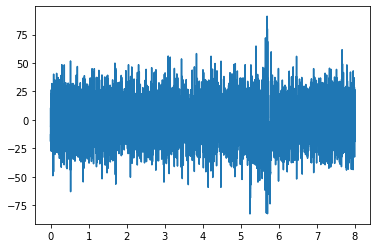

In [ ]:

DATA_GENERATION(1)


In [ ]:
import shutil
shutil.make_archive('/content/Positive Training DATA', 'zip', 'Positive Training DATA')


'/content/Positive Training DATA.zip'

In [ ]:
! unzip -q /content/Positive Training DATA.zip

unzip:  cannot find or open /content/Positive, /content/Positive.zip or /content/Positive.ZIP.
